# Preliminary operations

Import libraries.

In [1]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import IPython.display as ipd 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
import tarfile
from shutil import copyfile
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow

Extracting data.

In [2]:
drive.mount('/content/gdrive', force_remount = True)
copyfile('gdrive/My Drive/DSIM/E02/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

Mounted at /content/gdrive


## Data loader

In [3]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

# Feature extraction

Now, let's create the functions to extract the Spectrogram, the Mel Spectrogram and the MFCC.

## Spectrogram

In [28]:
def feats_spectrogram(input, rate = 8000, tsize = 10):
  # Extract 2-D feature
  spec_freqs, spec_times, spec = spectrogram(input*1.0, fs = rate)
  # Force matrix width = tsize
  spec = spec[:,0:min(tsize, spec.shape[1])]
  spec_pad = np.pad(spec, [(0, 0), (0, tsize - spec.shape[1])], mode = 'constant')
  # Unroll 2-D matrix, through flatten method
  output = spec_pad.flatten()
  return output

In [29]:
X_train, X_test, y_train, y_test = load_data(feature_extractor = feats_spectrogram, normalize = True)

In [30]:
param_grid = {'C': [100, 500, 1000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]
              }

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced'), param_grid, cv = 2)
clf = clf.fit(X_train, y_train)
print(clf.best_params_)

{'C': 1000, 'gamma': 0.005}


The best values for C and gamma are, respectively, 1000 and 0.005. We can try to see if there is a better combination which guarantees higher performances.

In [32]:
param_grid = {'C': [1000, 5000, 10000],
              'gamma': [0.00001, 0.0001, 0.001, 0.005, 0.01]
              }

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced'), param_grid, cv = 2)
clf = clf.fit(X_train, y_train)
print(clf.best_params_)

{'C': 1000, 'gamma': 1e-05}


A higher value for C does not improve the performances, so the best values are 1000 for C and 0.00001 for gamma.

In [33]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.53      0.67        17
           1       0.50      0.60      0.55        10
           2       0.67      0.93      0.78        15
           3       0.89      0.42      0.57        19
           4       1.00      0.73      0.84        11
           5       1.00      0.57      0.73        14
           6       0.24      0.86      0.38        14
           7       0.82      0.47      0.60        19
           8       1.00      0.59      0.74        17
           9       0.91      0.71      0.80        14

    accuracy                           0.63       150
   macro avg       0.79      0.64      0.66       150
weighted avg       0.81      0.63      0.66       150



Through the Spectrogram feature and the hyper-parameters optimization, we reach the 63% accuracy.

Text(0, 0.5, 'Prediction')

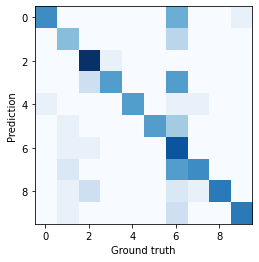

In [34]:
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

As we can see from the image above, the classification achieves quite good results, except for the class 6. The diagonal of the matrix is quite visible, but the class 6 is predicted with very low precision.

## Mel Spectrogram

In [35]:
def feats_mel_spectrogram(input, rate = 8000, tsize = 10):
  # Extract 2-D feature
  mel = melspectrogram(input*1.0, sr = rate)
  # Force matrix width = tsize
  mel = mel[:,0:min(tsize, mel.shape[1])]
  mel_pad = np.pad(mel, [(0, 0), (0, tsize - mel.shape[1])], mode = 'constant')
  # Unroll 2-D matrix, through flatten method
  output = mel_pad.flatten()
  return output

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor = feats_mel_spectrogram, normalize = True)

In [37]:
param_grid = {'C': [100, 500, 1000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]
              }

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced'), param_grid, cv = 2)
clf = clf.fit(X_train, y_train)
print(clf.best_params_)

{'C': 1000, 'gamma': 0.005}


The best values for C and gamma are, respectively, 1000 and 0.005. We can try to see if there is a better combination which guarantees higher performances.

In [38]:
param_grid = {'C': [1000, 5000, 10000],
              'gamma': [0.00001, 0.0001, 0.001, 0.005, 0.01]
              }

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced'), param_grid, cv = 2)
clf = clf.fit(X_train, y_train)
print(clf.best_params_)

{'C': 5000, 'gamma': 1e-05}


We found better values for C (5000) and gamma (0.00001).

In [39]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.47      0.64        17
           1       0.75      0.60      0.67        10
           2       0.72      0.87      0.79        15
           3       0.90      0.47      0.62        19
           4       0.21      0.82      0.34        11
           5       1.00      0.64      0.78        14
           6       1.00      0.43      0.60        14
           7       0.83      0.53      0.65        19
           8       0.57      0.76      0.65        17
           9       0.79      0.79      0.79        14

    accuracy                           0.63       150
   macro avg       0.78      0.64      0.65       150
weighted avg       0.79      0.63      0.66       150



The accuracy didn't change with respect to the "vanilla" Spectrogram.

Text(0, 0.5, 'Prediction')

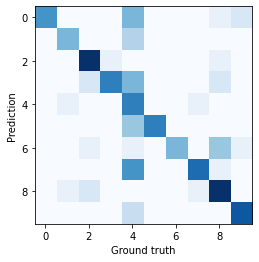

In [40]:
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

The matrix is quite similar to the one above regarding the Spectrogram. However, now the class 6 is predicted with a higher precision. Nonetheless, now we have problems with the prediction of the class 4.

## MFCC

In [44]:
def feats_MFCC(input, rate = 8000, tsize = 10):
  # Extract 2-D feature
  mfccs = mfcc(input*1.0, sr = rate)
  # Force matrix width = tsize
  mfccs = mfccs[:,0:min(tsize, mfccs.shape[1])]
  mfccs_pad = np.pad(mfccs, [(0, 0), (0, tsize - mfccs.shape[1])], mode = 'constant')
  # Unroll 2-D matrix, through flatten method
  output = mfccs_pad.flatten()
  return output

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor = feats_MFCC, normalize = True)

In [46]:
param_grid = {'C': [100, 500, 1000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]
              }

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced'), param_grid, cv = 2)
clf = clf.fit(X_train, y_train)
print(clf.best_params_)

{'C': 100, 'gamma': 0.005}


The best values for C and gamma are, respectively, 100 and 0.005. We can try to see if there is a better combination which guarantees higher performances.

In [47]:
param_grid = {'C': [100, 500, 1000],
              'gamma': [0.00001, 0.0001, 0.001, 0.005, 0.01]
              }

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced'), param_grid, cv = 2)
clf = clf.fit(X_train, y_train)
print(clf.best_params_)

{'C': 100, 'gamma': 0.005}


We didn't find better values for C and gamma.

In [48]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       0.93      1.00      0.97        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



The accuracy increased by 36% with respect to the other approaches.

Text(0, 0.5, 'Prediction')

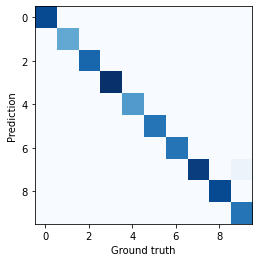

In [49]:
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

The diagonal of the matrix is clearly visible. We obtained an optimal classification result, so clearly the MFCC is the feature that allows the best classification, compared to the Spectrogram and the Mel Spectrogram.